In [ ]:
%uv pip install numerapi pyarrow numerai-tools lightgbm -q

In [ ]:
import json
import warnings

import pandas as pd
import numpy as np

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr

from sklearn.linear_model import Ridge 
import lightgbm as lgb

np.random.seed(42)


# Introduction

Lets start by loading the train and validation dataset

In [ ]:
DATA_VERSION = "v5.1"
napi = NumerAPI()

napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)

# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "target"] + feature_set
)


#Keep the last 100th eras for test set
validation_era = validation["era"].unique()[:-100]
validation = validation[validation["era"].isin(validation_era)]

2025-12-16 15:56:27,055 INFO numerapi.utils: target file already exists
2025-12-16 15:56:27,056 INFO numerapi.utils: download complete


We remove first validation eras to prevent data leakage.

In [ ]:

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]

validation = validation[~validation["era"].isin(eras_to_embargo)]

### Motivation

The goal of this notebook is to run some experiments with different features selection.

We then check for some metrics on validation dataset which will allow us to decide which set of features to keep.

### Performance evaluation

Numerai calculates scores designed to "align incentives" between your model and the hedge fund - a model with good scores should help the hedge fund make good returns. The primary scoring metrics in Numerai are:

- `CORR` (or "Correlation") which is calculated by the function [numerai_corr](https://docs.numer.ai/numerai-tournament/scoring/correlation-corr) - a Numerai specific variant of the Pearson Correlation between your model and the target.

- `MMC` (or "Meta Model Contribution") which is a calculated by the function `correlation_contribution` - a measure of how uniquely additive your model is to the Numerai Meta Model.

Our goal in this project is to maximize `CORR` to have the "best" strategy.


To assess the quality of a prediction, we will use the following metrics:

-  `mean`: Average correlation over the eras: Indicator of the raw performance of the model

- `std`: Standard deviation over the eras: Indicator of the stability of a model.

- `corr_sharpe`: Sharp ratio of the correlation: Indicator of how risky the model is.

- `corr_max_drawdown`: Max drowdown of the model: Indicator of how much we may lose.

- `hit_rate`: Success rate indicator.



In [ ]:


def fit_and_evaluate_model(model, train, validation, feature_set):
    """
    Fit a model and evaluate it on validation data.
    
    Parameters:
    -----------
    model : sklearn/LightGBM model
        Model to fit and evaluate
    train : pandas.DataFrame
        Training data with features and target
    validation : pandas.DataFrame
        Validation data with features and target
    feature_set : list
        List of feature names to use for training and prediction
    
    Returns:
    --------
    per_era_corr : pandas.Series
        Per-era correlation scores
    """
    # Fit model and make predictions
    model.fit(train[feature_set], train["target"])
    validation["prediction"] = model.predict(validation[feature_set])

    # Compute per-era correlation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        per_era_corr = validation.groupby("era").apply(
            lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()),
            include_groups=False
        )
        per_era_corr.fillna(0, inplace=True)

    # Compute performance metrics
    corr_mean = per_era_corr.mean().item()
    corr_std = per_era_corr.std(ddof=0).item()
    corr_sharpe = corr_mean / corr_std if corr_std > 0 else np.nan
    corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max().item()
    corr_hit_rate = (per_era_corr > 0).mean().item()


    # Display performance metrics
    print("=" * 60)
    print("MODEL PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Mean:           {corr_mean:>10.6f}")
    print(f"Std:            {corr_std:>10.6f}")
    print(f"Sharpe:         {corr_sharpe:>10.4f}")
    print(f"Max Drawdown:   {corr_max_drawdown:>10.6f}")
    print(f"Hit Rate:       {corr_hit_rate:>10.2%}")
    print()

    # Compute feature exposures
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        feature_exposures = validation.groupby("era").apply(
            lambda d: d.drop(columns=["target", "prediction"]).corrwith(d["prediction"]),
            include_groups=False
        )
        feature_exposures.fillna(0, inplace=True)

    # Display feature exposure metrics
    max_feature_exposure = feature_exposures.max(axis=1)
    print("FEATURE EXPOSURE")
    print("=" * 60)
    print(f"Max Feature Exposure - Mean: {max_feature_exposure.mean():.4f}")
    print(f"Max Feature Exposure - Std:  {max_feature_exposure.std():.4f}")
    print("=" * 60)
    print()

    return per_era_corr

# Baseline

We use a linear regression as baseline. Its performances are quite mediocre.

corr_mean
0.017416736285571645
corr_std
0.0
corr_sharpe
nan
MODEL PERFORMANCE METRICS
Mean:             0.017417
Std:              0.000000
Sharpe:                nan
Max Drawdown:     0.000000
Hit Rate:          100.00%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.1631
Max Feature Exposure - Std:  nan



<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

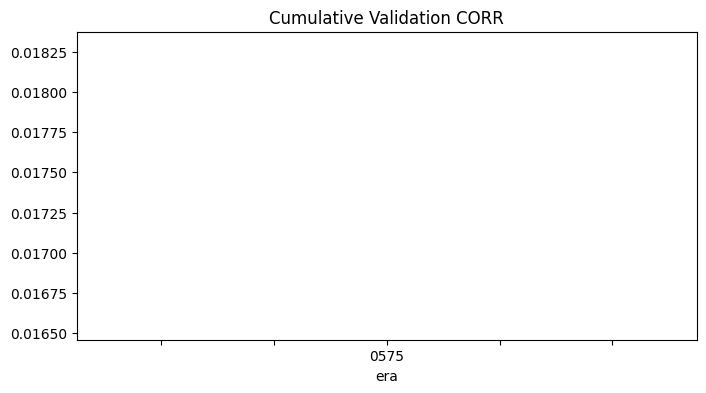

In [ ]:
model = Ridge(alpha=10, random_state=42)

per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

# LightGBM

We then use a Light Gradient-Boosting Machine which is a very good model for large features dataset with binned data.

It allow to draw any boundary decision.

## Feature Set All

We first try to fit that model on the whole dataset.

MODEL PERFORMANCE METRICS
Mean:             0.000000
Std:              0.000000
Sharpe:                nan
Max Drawdown:     0.000000
Hit Rate:            0.00%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.0000
Max Feature Exposure - Std:  nan



<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

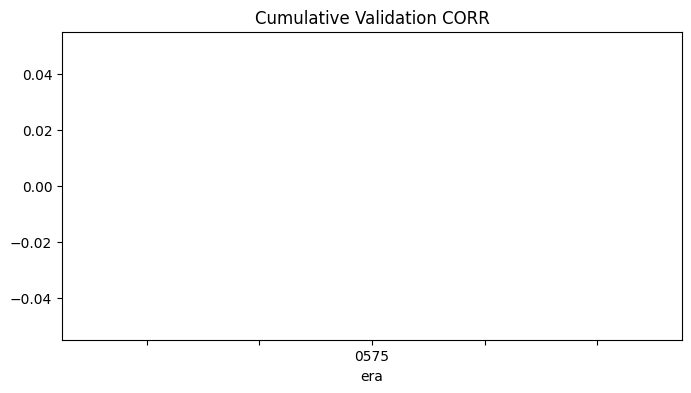

In [ ]:
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1,
  verbose=-1,
  seed=42
  )

per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

### Feature selection via previous feature importance

One regularization method we try is to actually select the features with the most important decision power according the previous trained model.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 137800, number of used features: 50
[LightGBM] [Info] Start training from score 0.500009
performances: 
                                               CORR
mean          prediction    0.006468
dtype: float64
std           prediction    0.017558
dtype: float64
sharpe        prediction    0.368392
dtype: float64
max_drawdown  prediction    0.027083
dtype: float64
hit_rate      prediction    0.555556
dtype: float64
max feature exposure mean: 0.22
max feature exposure std: 0.02
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

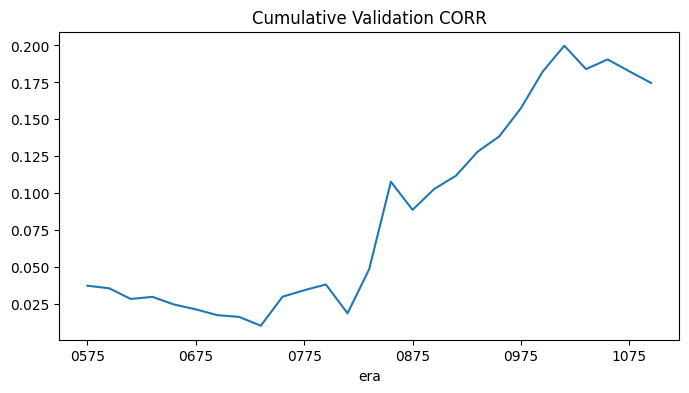

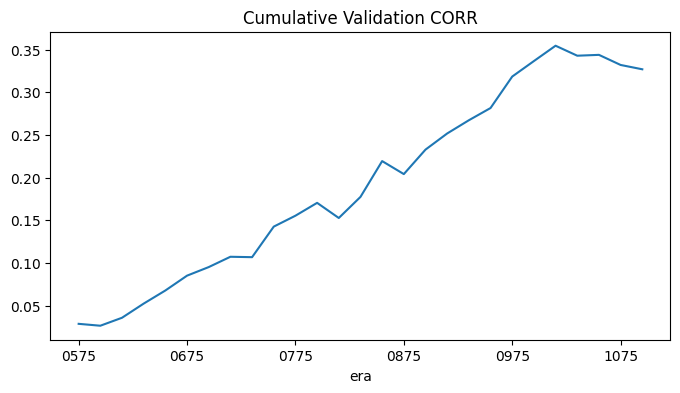

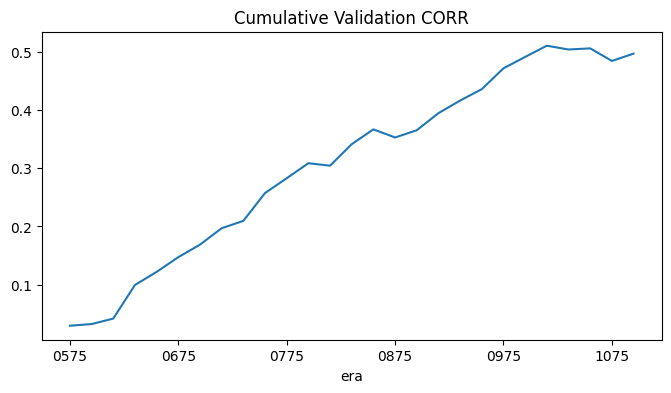

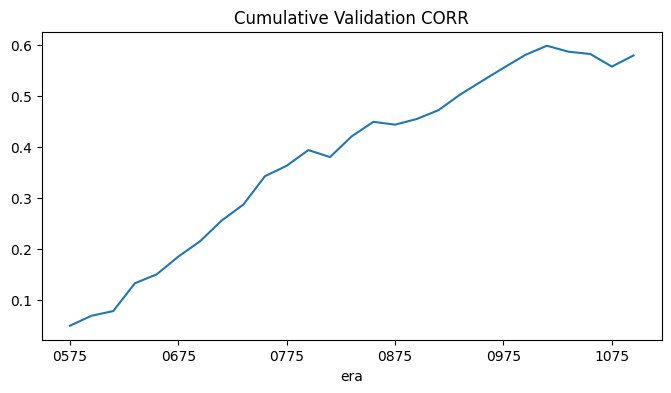

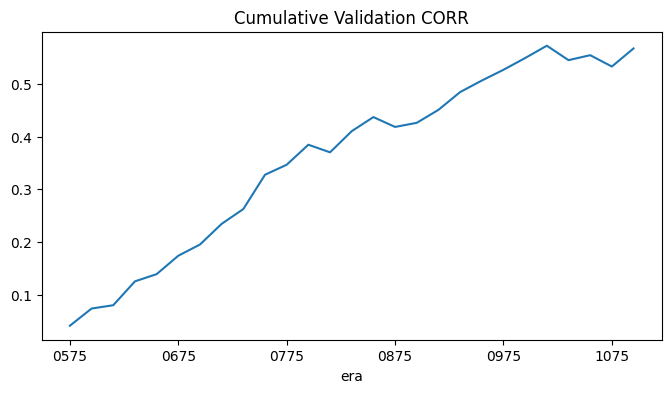

In [ ]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

for n in [100, 200, 500, 1000]:
  top_features = [feature_set[i] for i in sorted_idx[:n]]
  model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1,
    verbose=-1,
    seed=42
    )

  per_era_corr = fit_and_evaluate_model(model, train, validation, top_features)


### Feature selection via correlation sharp ratio

One regularization method we try is by selecting only the 1000 features with the highest correlation sharp ratio

In [ ]:
n_splits = 15
n_features = 1000

# Split dataset into n_splits parts
n_samples = len(train)
samples_per_split = n_samples // n_splits

# Store correlations for each split
split_corrs = []

for i in range(n_splits):
    start_idx = i * samples_per_split
    end_idx = (i + 1) * samples_per_split if i < n_splits - 1 else n_samples
    
    split_data = train.iloc[start_idx:end_idx]
    
    # Compute correlation for this split
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        corr = split_data.drop(columns=["era", "target"]).corrwith(
            split_data['target'], method='pearson'
        )
    
    # Set NaN (from zero variance) to 0
    corr = corr.fillna(0)
    
    split_corrs.append(corr)

# Convert to DataFrame (rows = splits, columns = features)
split_corr_df = pd.DataFrame(split_corrs)

# Compute statistics across splits
feature_mean_corr_split = split_corr_df.mean(axis=0).abs()  # Mean correlation per feature
feature_std_corr_split = split_corr_df.std(axis=0)  # Std across splits
feature_sharp_corr_split = feature_mean_corr_split / feature_std_corr_split  # Sharpe ratio

feature_set_sharp = feature_sharp_corr_split.sort_values(ascending=False).index[:n_features]


In [ ]:
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1,
  verbose=-1,
  seed=42
  )
  
per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set_sharp)


# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

## Feature Set Medium

Now we try to fit the model only on the features from the medium dataset

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3700
[LightGBM] [Info] Number of data points in the train set: 137800, number of used features: 740
[LightGBM] [Info] Start training from score 0.500009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
performances: 
                                               CORR
mean          prediction    0.024371
dtype: float64
std           prediction    0.024719
dtype: float64
sharpe        prediction    0.985894
dtype: float64
max_drawdown  prediction    0.030034
dtype: float64
hit_rate      pre

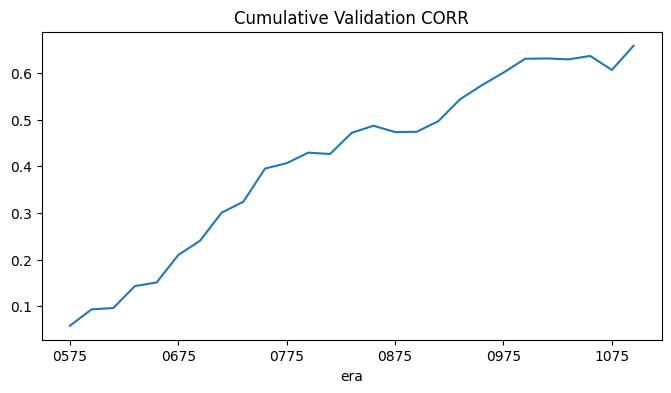

In [ ]:
feature_set_medium = feature_sets["medium"]

model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1,
  verbose=-1,
  seed=42
  )
  
per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set_medium)


# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

TODO complete analysis